In [1]:
import osqp
import numpy as np
import scipy as sp
from scipy import sparse

In [2]:
#Modelo do processo
def reatorWilliamsOtto(t,x,d1,u1,u2,d2):
  #Estados do sistema
  Xa = float(x[0])
  Xb = float(x[1])
  Xc = float(x[2])
  Xe = float(x[3])
  Xg = float(x[4])
  Xp = float(x[5])

  FA = d1
  uk1 = u1
  uk2 = u2
  W  = d2
  
  #Parâmetros
  k10 = 1.6599e6
  k20 = 7.2117e8
  k30 = 2.6745e12
  E1 = 6666.7
  E2 = 8333.3
  E3 = 11111

  #Cálculos adicionais
  k1 = k10*np.exp(-E1/(uk2+273))
  k2 = k20*np.exp(-E2/(uk2+273))
  k3 = k30*np.exp(-E3/(uk2+273))
  r1 = k1*Xa*Xb*W
  r2 = k2*Xb*Xc*W
  r3 = k3*Xc*Xp*W

  #Modelo matemático
  dXa = FA/W - (FA + uk1)*(Xa/W) - r1/W
  dXb = uk1/W - (FA + uk1)*(Xb/W) - r1/W - r2/W
  dXc = - (FA + uk1)*(Xc/W) + 2*r1/W - 2*r2/W - r3/W
  dXe = - (FA + uk1)*(Xe/W) + 2*r2/W
  dXg = - (FA + uk1)*(Xg/W) + 1.5*r3/W
  dXp = - (FA + uk1)*(Xp/W) + r2/W - 0.5*r3/W

  dxdt = np.array([dXa,dXb,dXc,dXe,dXg,dXp])

  return dxdt

In [3]:
from scipy.signal import tf2ss
!pip install control
import control as cnt
#Funções de transferência
num = [[[-0.0001265],[0.00169]],[[-0.0000645,-0.00000007833],[-0.000002683]]]
den = [[[1,0.00486],[1,0.9468]],[[1,0.01305,0.00002397],[1,0.003851]]]
#G = cnt.TransferFunction(num,den)
H = cnt.tf(num,den)
print(H)

     |████████████████████████████████| 348kB 6.9MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344929 sha256=8d71676e5ba272cb3e4e87a565109eac802b4081d41c32c247d4ff04a5c00078
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control

Input 1 to output 1:
-0.0001265
-----------
s + 0.00486

Input 1 to output 2:
  -6.45e-05 s - 7.833e-08
---------------------------
s^2 + 0.01305 s + 2.397e-05

Input 2 to output 1:
 0.00169
----------
s + 0.9468

Input 2 to output 2:
 -2.683e-06
------------
s + 0.003851



In [4]:
#Convertendo o sistema em espaço de estados
!pip install slycot
from slycot import td04ad
Gss = cnt.ss(H)
print(Gss)

     |████████████████████████████████| 1.6MB 7.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417856 sha256=155a97eccca4475a2f990e079ac1c31be0501a3dda347ec8e99a8e60cc6f7096
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot
A = [[-9.50651000e-01  3.03576608e-17  3.64612680e-02  1.48445230e-16
       1.80888389e-16]
     [ 0.00000000e+00 -1.79100000e-02  1.21430643e-17 -8.73930000e-03
      -1.16494200e-03]
     [-1.00000000e-01  1.21430643e-17  2.93592226e-18 -2.44447918e-17
       1.39327248e-17]
     [ 0.00000000e+00  1.00000000e-02  2.34349675e-18 -2.47208790e-17
      -1.59923665e-17]
     [ 0.00000000e+00  0.00000000e+00 -6.93889390e-18  1.00000000e-02
      -1.64798730e-17]]

B = [[-2.08166817e-17 -1.00000000e+00]
     [ 1.00000000

In [5]:
#Gerando as matrizes do MPC incremental com restrição
def mpcgain_MIMO_Constrained(A,B,C,m,p,Q,nx,nu,ny):
  A_e = np.eye(nx+ny,nx+ny)
  A_e[0:nx,0:nx] = A
  A_e[nx:nx+ny+1,0:nx] = C.dot(A)
  B_e = np.zeros([nx+ny,nu])
  B_e[0:nx,:] = B
  B_e[nx:nx+ny+1,:] = C.dot(B)
  C_e = np.zeros([ny,nx+ny])
  C_e[:,nx:nx+ny+1] = np.eye(ny,ny)
  
  n = nx+ny
  h = np.zeros([p*ny,nx+ny])
  F = np.zeros([p*ny,nx+ny])
  
  h[0:ny,:] = C_e
  F[0:ny,:] = C_e.dot(A_e)

  for kk in range(ny,p*ny,nu):
    h[kk:kk+ny,:] = h[kk-ny:kk,:].dot(A_e)
    F[kk:kk+ny,:] = F[kk-ny:kk,:].dot(A_e)
  
  v = h.dot(B_e)
  Phi = np.zeros([p*nu,m*nu])
  Phi[:,0:nu] = v
  Phi[:,nu:2*nu] = np.r_[np.zeros([nu,nu]),[v[0,:],v[1,:],v[2,:],v[3,:],v[4,:],v[5,:],v[6,:],v[7,:]]]
  Phi[:,2*nu:3*nu] = np.r_[np.zeros([2*nu,nu]),[v[0,:],v[1,:],v[2,:],v[3,:],v[4,:],v[5,:]]]
  #for i in range(nu,nu*m,nu):
   # Phi[:,i:i+nu] = np.r_[np.zeros([i,nu]),[v[0,:],v[1,:],v[2,:],v[3,:]]]

  
  z = (ny*p,1)
  Bars = np.ones(z)
  Phi_T = np.transpose(Phi)
  #print(Phi_T)
  aa = Phi_T.dot(Q)
  Phi_Phi = aa.dot(Phi)
  #Phi_Phi = Phi_T*Q*Phi
  bb = Phi_T.dot(Q)
  Phi_F = aa.dot(F)
  #Phi_F = Phi_T*Q*F
  Phi_R = Phi_T.dot(Bars)

  return Phi_Phi, Phi_F, Phi_R, A_e, B_e, C_e 
  

In [6]:
def Kalman_Filter(arg1_1,arg1_2,arg1_3,arg1_4):
  Ad = arg1_1
  Cd = arg1_2
  nx = arg1_3
  ny = arg1_4
  W_kf = np.eye(nx)
  V_kf = np.eye(ny)
  P_Kf = np.eye(nx)

  for i in range(1,1000):
    K = ((Ad.dot(P_Kf)).dot(np.transpose(Cd))).dot(np.linalg.inv(V_kf+(Cd.dot(P_Kf)).dot(np.transpose(Cd))))
    P_kf = (Ad.dot(P_Kf)).dot(np.transpose(Ad)) - ((((Ad.dot(P_Kf)).dot(np.transpose(Cd))).dot(np.linalg.inv(V_kf+(Cd.dot(P_Kf)).dot(np.transpose(Cd)))).dot(Cd)).dot(P_Kf)).dot(np.transpose(Ad)) + W_kf

  return K

In [7]:
#Função para calcular as restrições da programação quadrática
def RestU(arg1,arg2,arg3):

  nu = arg1
  m  = arg2
  uk_1 = arg3

  ukk_1 = uk_1

  for k in range(1,m):
    ukk_1 = np.r_[ukk_1,uk_1]

  C2 = np.zeros([nu*m,nu*m])

  for k in range(0,nu*m):
    for j in range(0,nu*m):
      if k>=j:
        C2[k,j] = 1
  return C2, ukk_1

In [8]:
!pip install qpsolvers
from qpsolvers import solve_qp

     |████████████████████████████████| 276kB 10.2MB/s 
  Created wheel for quadprog: filename=quadprog-0.1.8-cp37-cp37m-linux_x86_64.whl size=336647 sha256=160c432f7da317581b6005df4a4a8c4c3504c4a706eca80419c9beffbfe876a5
  Stored in directory: /root/.cache/pip/wheels/0c/39/5f/c712b0e462439dec9b30080cf34622f167929b39bd964d8baf
Successfully built quadprog


In [9]:
pip install cvxopt

In [10]:
from cvxopt import matrix, solvers

In [11]:
def cvxopt_solve_qp(P, q, G, h, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [matrix(P), matrix(q)]
    if G is not None:
        args.extend([matrix(G), matrix(h)])
        if A is not None:
            args.extend([matrix(A), matrix(b)])
    sol = solvers.qp(*args)
    #print(np.array(sol['x']).reshape((P.shape[1],)))
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((P.shape[1],))

In [12]:
from numpy import dot

In [13]:
#Controlador MPC
def MPC(arg1,arg2,arg3,arg4,arg5,arg6,arg7,
        arg8,arg9,arg10,arg11,arg12,arg13,
        arg14,arg15,arg16,arg17,arg18,arg19,
        arg20,arg21,arg22,arg23,arg24,arg25,
        arg26,arg27,arg28):
  ypk = arg1
  Yset = arg2
  ts = arg3
  p = arg4
  m = arg5
  Phi_Phi = arg6 
  Phi_F = arg7
  Phi_R = arg8
  A_e = arg9 
  B_e = arg10 
  C_e = arg11
  xm = arg12
  Xf = arg13
  nx = arg14 
  ny = arg15 
  nu = arg16
  n = arg17
  n_in = arg18
  Q = arg19
  R = arg20
  uk_1 = arg21
  #print(uk_1)
  Dumax = arg22
  Dumin = arg23
  Umax = arg24
  Umin = arg25
  Ad = arg26
  Bd = arg27
  Cd = arg28
  #print(ypk)
  #Filtro de Kalman
  K = Kalman_Filter(A,C,nx,ny)
  #K = np.array([[1],[1],[0],[0],[0]])
  #Calculando o setpoint
  #Yset = np.array([[ysp1],[ysp2]])
  #Yset = np.array([[ysp1],[ysp2]])
  #ypk = np.array([[yp1],[yp2]])
  #print(Yset)
  #Matriz Hessiana da função quadrática otimizada
  H1 = (Phi_Phi + R)
  #print(H1)
  #função ct
  ct = -(Phi_F[:,n-(ny):n].dot(Yset)-Phi_F.dot(Xf))
  #print(ct)
  Pe = dot(H1.T, H1)  # quick way to build a symmetric matrix 
  
  #Matrizes de restrição do controlador
  C1 = np.eye(nu*m)
  C2, ukk_1 = RestU(nu,m,uk_1)
  A1_1 = np.r_[C1, -C1, C2, -C2]
  b1_1 = np.r_[Dumax, Dumax, Umax-ukk_1, -Umin+ukk_1]
  #print(H1)
  #print(ct)
  #A1_1 = np.r_[C2,-C2]
  #b1_1 = np.r_[Umax-ukk_1, -Umin+ukk_1]
  #Programação quadrática
  Deltau = cvxopt_solve_qp(H1, ct, A1_1, b1_1, A=None, b=None)
  #Seleção dos primeiros valores da sequência ótima das variáveis manipuladas
  deltau = np.array([[Deltau[0]],[Deltau[1]]])
  #print(Deltau)

  #Atualização da variável manipulada
  u = uk_1 + deltau

  #Atualização das variáveis de estado do modelo MPC
  xm_old = xm
  xm = Ad.dot(xm_old) + Bd.dot(u)
  #Correção do estado para cálculo da saída pelo filtro de Kalman
  ym  = Cd.dot(xm)
  xmk = xm + K.dot(ypk) - K.dot(ym)
  xm  = xmk

  #Variáveis para o modelo incremental
  y  = Cd.dot(xmk)
  Xf = np.r_[xm-xm_old,y]

  return y, u, Xf, xm


In [14]:
#Parâmetros do processo e de simulação
dt = 30
tinicial = 0
tfinal = 300*dt
FA = 1.8275

#condição inicial
u0 = np.array([[4.20272190259943],[85.9672169199226]])
uk_1 = np.array([[0],[0]])
uss = np.array([[4.20272190259943],[85.9672169199226]])
W  = 2118.15669779829
x0 = np.array([[0.108520660862867],[0.354880412893655],[0.0196295819273198],[0.295053132157847],[0.111584469119082],[0.110331743039229]])
xss = np.array([[0.108520660862867],[0.354880412893655],[0.0196295819273198],[0.295053132157847],[0.111584469119082],[0.110331743039229]])
y  = np.array([[0.295053132157847],[0.110331743039229]])
yss  = np.array([[0.295053132157847],[0.110331743039229]])

#Definindo o setpoint
ysp  = np.array([[0.295053132157847],[0.110331743039229]])

#Definindo os horizontes de predição e de controle
p = 5
m = 3

#Matrizes do sistema ss
A = np.array([[0.864330552009586,0,0,0,0],
             [0,0.667712731567332,-0.151784519965271,0,0],
             [0,0.0966227773509761,0.990510106141473,0,0],
             [0,0,0,4.61635858349997e-13,0],
             [0,0,0,0,0.890893845020821]])

B = np.array([[0.436180066841609,0],
              [0.193245554701952,0],
              [0.0120821267094521,0],
              [0,0.0330059146598918],
              [0,0.0553357462850450]])

C = np.array([[-0.00811520000000000,0,0,0.0540800000000000,0],
              [0,-0.00825600000000000,-0.00256671744000000,0,-0.00137369600000000]])

D = np.array([[0.,0.],
              [0.,0.]])

#definindo o tamanho do sistema
nx = np.size(B, 0)
nu = np.size(B, 1)
ny = np.size(C, 0)

#Parâmetros do controlador
#Q = np.eye(10)
#R = np.eye(6)

qqq = np.array([10000,10000,10000,10000,10000,
                10000,10000,10000,10000,10000])
Q = np.diag(qqq)

rrr = np.array([0.01,0.01,0.01,
                0.01,0.01,0.01])
R = np.diag(rrr)

#print(Q)
#Armazenando variáveis do modelo do MPC
Phi_Phi, Phi_F, Phi_R, A_e, B_e, C_e = mpcgain_MIMO_Constrained(A,B,C,m,p,Q,nx,nu,ny)
xm_1 = np.zeros([nx,1])
n = np.size(B_e, 0)
Xf_1 = np.zeros([n,1])
n_in = np.size(B_e, 1)

#Incremento de controle
dumax = np.array([[0.5], [2]])
dumin = np.array([[-0.5], [-2]])

Dumax = dumax
Dumin = dumin

for i in range(1,3):
  Dumax = np.r_[Dumax,dumax]
  Dumin = np.r_[Dumin,dumin]

#Limite das variáveis de controle
umax = np.array([[10-4.20272190259943], [150-85.9672169199226]])
umin = np.array([[2-4.20272190259943], [50-85.9672169199226]])

Umax = umax
Umin = umin

for i in range(1,3):
  Umax = np.r_[Umax,umax]
  Umin = np.r_[Umin,umin]

#Alocação de variáveis
t0 = tinicial
y1 = []
y2 = []
ySet1 = []
ySet2 = []
TT = []
u11 = []
u22 = []
FAA = []

In [15]:
#qq = [500,500,500,5]
#rr = np.array([0.1,10])

#aux1 = []
#for i in range(0,p*ny):
#  aux1.append(qq)

#Q = np.diag(np.diag(aux1))

#aux2 = []
#for i in range(0,m*nu):
 # aux2.append(rr)
#print(aux1)

In [16]:
from scipy.integrate import ode

#Parâmetros para simulação do reator
r = ode(reatorWilliamsOtto)

#Simulação do reator
while r.successful() and r.t < tfinal:
  r.set_initial_value(x0, t0)
  r.set_f_params(FA,u0[0],u0[1],W)
  #if r.t >= 3000:
    #u0[0] = 8
  if r.t >= 3000:
    ysp  = np.array([[1*(0.226538374444692-0.295053132157847)*(1-np.exp((-(r.t-3000)/154)))+0.295053132157847],
                     [1*(0.0909106105441988-0.110331743039229)*(1-np.exp((-(r.t-3000)/195)))+0.110331743039229]])
    #FA = 3.2
  #if r.t >= 6000:
    #FA = 1.8275
  #print(r.t+dt, r.integrate(r.t+dt))
  #y1.append(r.integrate(r.t+dt)[3])
  yy = r.integrate(r.t+dt)

  yp1 = yy[3]
  yp2 = yy[5]
  ypp = np.array([yp1,yp2])
  yp = ypp-yss
  
  yspp = ysp-yss
  #print(yspp)
  
  #uk0 = u0-uss
  #print(uk0)
  
  yk, uk, Xfk, xmkk = MPC(yp,yspp,r.t,p,m,
                     Phi_Phi,Phi_F,Phi_R,A_e,B_e,C_e,
                     xm_1,Xf_1,nx,ny,nu,n,n_in,
                     Q,R,uk_1,Dumax,Dumin,
                     Umax,Umin,A,B,C)
  u0 = uk+uss
  uk_1 = uk
  Xf_1 = Xfk
  xm_1 = xmkk

  y1.append(yk[0]+yss[0])
  y2.append(yk[1]+yss[1])
  ySet1.append(ysp[0])
  ySet2.append(ysp[1])
  u11.append(u0[0])
  u22.append(u0[1])
  FAA.append(FA)
  TT.append(r.t)
  x0 = r.y
  t0 = r.t
  #print(x0)


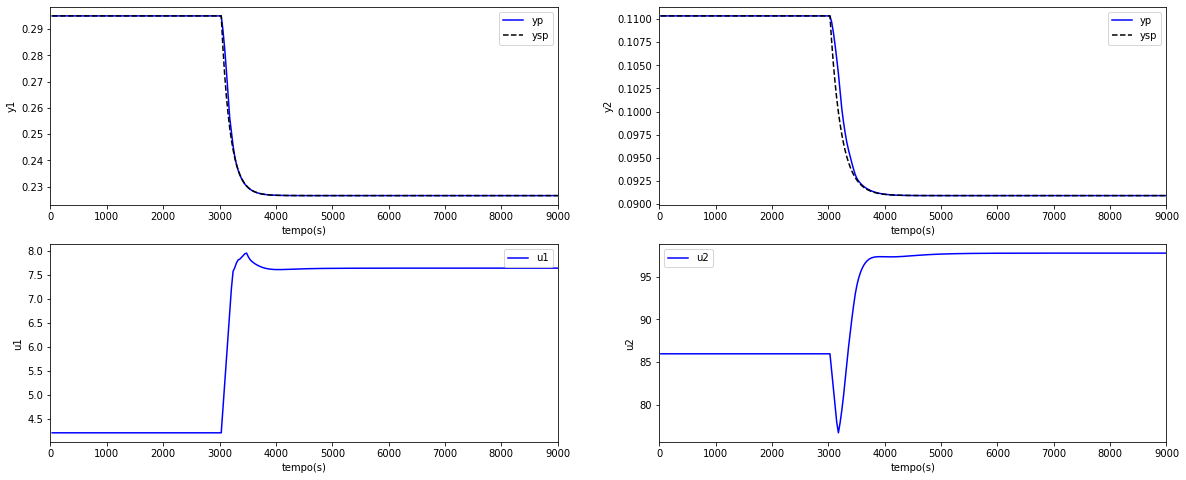

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import FixedFormatter
#from matplotib import ticker
plt.rcParams['figure.figsize'] = (20,8)
ax1 = plt.subplot(221)
ax1.plot(TT,y1,'b-', label = 'yp')
ax1.plot(TT,ySet1,'k--', label = 'ysp')
ax1.set_xlabel('tempo(s)')
ax1.set_ylabel('y1')
ax1.set_xlim([0,9000])
#ax1.set_ylim([0.2950524,0.2950540])
#ax1.yaxis.set_major_formatter(FixedFormatter([0.2950524,0.2950528,
 #                                             0.2950532,0.2950536,
  #                                            0.2950540]))
#ax1.yaxis.set_major_locator(ticker.FixedLocator([0.2950524,0.2950528,
 #                                                0.2950532,0.2950536,
  #                                               0.2950540]))
ax1.legend(loc="best")

ax2 = plt.subplot(222)
ax2.plot(TT,y2,'b-', label = "yp")
ax2.plot(TT,ySet2,'k--', label = "ysp")
ax2.set_xlabel('tempo(s)')
ax2.set_ylabel('y2')
ax2.set_xlim([0,9000])
#ax2.set_ylim([0.1103310,0.1103330])
#ax2.yaxis.set_major_formatter(FixedFormatter([0.1103310,0.1103315,
 #                                             0.1103320,0.1103325,
  #                                            0.1103330]))
#ax2.yaxis.set_major_locator(ticker.FixedLocator([0.1103310,0.1103315,
 #                                                0.1103320,0.1103325,
  #                                               0.1103330]))
ax2.legend(loc="best")

ax3 = plt.subplot(223)
ax3.plot(TT,u11,'b-', label = "u1")
ax3.set_xlabel('tempo(s)')
ax3.set_ylabel('u1')
ax3.set_xlim([0,9000])
#ax3.set_ylim([4.2024,4.2032])
#ax3.yaxis.set_major_formatter(FixedFormatter([4.2024,4.2026,
 #                                             4.2028,4.2030,
  #                                            4.2032]))
#ax3.yaxis.set_major_locator(ticker.FixedLocator([4.2024,4.2026,
 #                                                4.2028,4.2030,
  #                                               4.2032]))
ax3.legend(loc="best")

ax4 = plt.subplot(224)
ax4.plot(TT,u22,'b-', label = "u2")
ax4.set_xlabel('tempo(s)')
ax4.set_ylabel('u2')
ax4.set_xlim([0,9000])
#ax4.set_ylim([85.9660,85.9680])
#ax4.yaxis.set_major_formatter(FixedFormatter([85.9660,85.9670,
 #                                             85.9680]))
#ax4.yaxis.set_major_locator(ticker.FixedLocator([85.9660,85.9670,
 #                                                85.9680]))
ax4.legend(loc="best")

In [18]:
print(FAA)

[1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275, 1.8275,